https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset

## LIBRERÍAS Y CARGA DE DATOS

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns
import glob 

In [155]:
def load_images_from_folder(folder, label):
    images = []
    labels = []  # Prepare a list to store the labels of the images
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (64, 64))  # Resize images to uniform size
            images.append(img)
            labels.append(label)
    return images, labels

# Paths to your datasets
tumor_path = 'C:/Users/apeny/Downloads/EJ/Brain Tumor'
non_tumor_path = 'C:/Users/apeny/Downloads/EJ/Healthy'

In [156]:
base_dir = 'C:/Users/apeny/Downloads/EJ'

## EXPLORACIÓN Y VISUALIZACIÓN DE DATOS

In [157]:
pd.DataFrame(os.listdir(base_dir),columns=['Files_Name'])

,Files_Name
0,Brain Tumor
1,Healthy


In [158]:
files = [i for i in glob.glob(base_dir + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,C:/Users/apeny/Downloads/EJ\Brain Tumor\Cancer...,EJ\Brain Tumor
1,C:/Users/apeny/Downloads/EJ\Healthy\Not Cancer...,EJ\Healthy
2,C:/Users/apeny/Downloads/EJ\Healthy\Not Cancer...,EJ\Healthy
3,C:/Users/apeny/Downloads/EJ\Healthy\Not Cancer...,EJ\Healthy
4,C:/Users/apeny/Downloads/EJ\Brain Tumor\Cancer...,EJ\Brain Tumor
...,...,...
4595,C:/Users/apeny/Downloads/EJ\Healthy\Not Cancer...,EJ\Healthy
4596,C:/Users/apeny/Downloads/EJ\Brain Tumor\Cancer...,EJ\Brain Tumor
4597,C:/Users/apeny/Downloads/EJ\Healthy\Not Cancer...,EJ\Healthy
4598,C:/Users/apeny/Downloads/EJ\Brain Tumor\Cancer...,EJ\Brain Tumor


C:\Users\apeny\AppData\Local\Temp\ipykernel_21368\3397800740.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe["Label"], palette=palette)


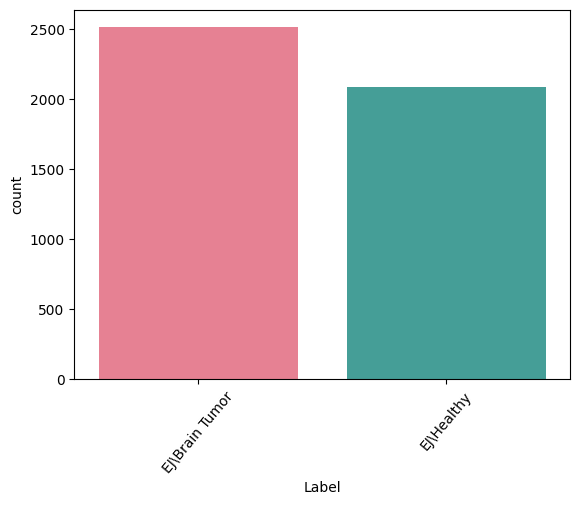

In [159]:
# Define una paleta de colores
palette = sns.color_palette("husl", len(dataframe["Label"].unique()))

# Crea el gráfico de barras con la paleta de colores
sns.countplot(x=dataframe["Label"], palette=palette)

# Rota las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=50)

# Muestra el gráfico
plt.show()

In [160]:
# Estadísticas descriptivas
dataframe.describe()

,Image,Label
count,4600,4600
unique,4600,2
top,C:/Users/apeny/Downloads/EJ\Brain Tumor\Cancer...,EJ\Brain Tumor
freq,1,2513


In [152]:
# Load images and labels from each category
tumor_images, tumor_labels = load_images_from_folder(tumor_path, 'Tumor')
non_tumor_images, non_tumor_labels = load_images_from_folder(non_tumor_path, 'Healthy')

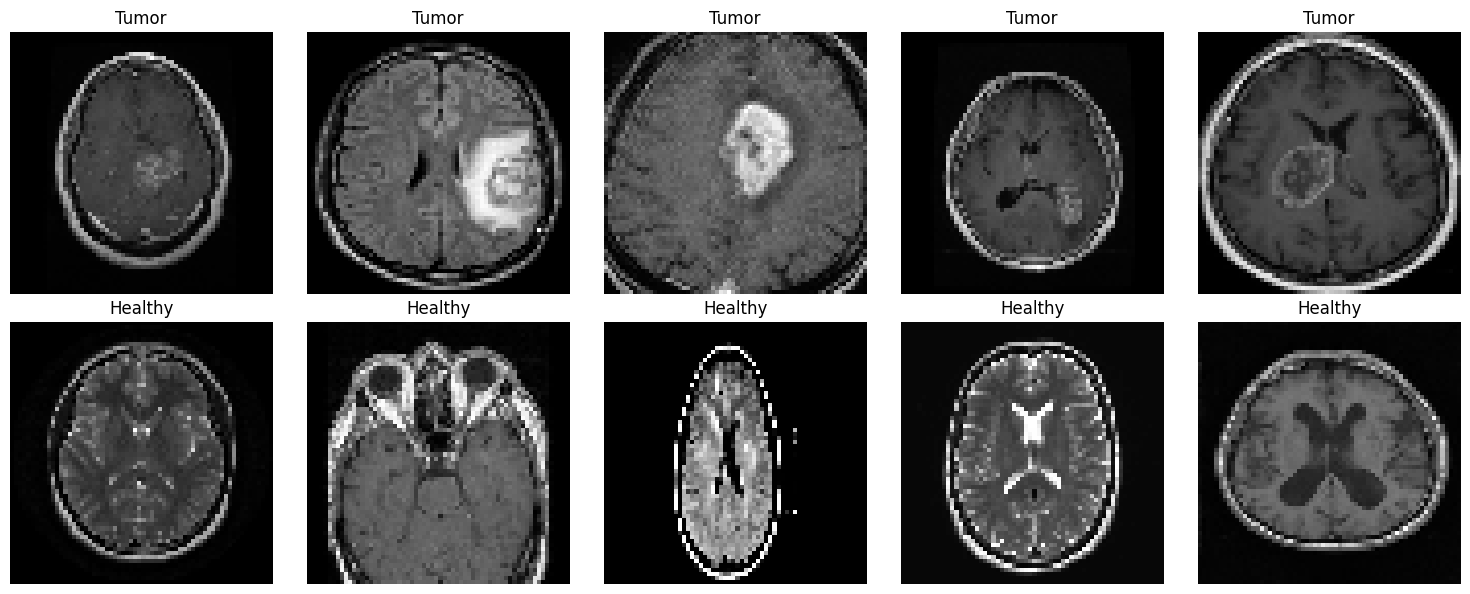

In [161]:
# Display images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows of images, 5 columns

# Ensure that the axes object is a 2D array
if len(tumor_images) < 5 or len(non_tumor_images) < 5:
    raise ValueError("Not enough images loaded for displaying.")

# Display tumor images
for i in range(5):
    ax = axes[0, i]  # Select the subplot
    ax.imshow(tumor_images[i], cmap='gray')
    ax.set_title('Tumor')
    ax.axis('off')

# Display non-tumor images
for i in range(5):
    ax = axes[1, i]  # Select the subplot
    ax.imshow(non_tumor_images[i], cmap='gray')
    ax.set_title('Healthy')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [90]:
print("Estadísticas de las Imágenes Sanas:")
print("Valor medio del píxel:", np.mean(non_tumor_images))
print("Mediana del valor del píxel:", np.median(non_tumor_images))
print("Desviación estándar de los valores de los píxeles:", np.std(non_tumor_images))

print("/nEstadísticas de las Imágenes con Tumor:")
print("Valor medio del píxel:", np.mean(tumor_images))
print("Mediana del valor del píxel:", np.median(tumor_images))
print("Desviación estándar de los valores de los píxeles:", np.std(tumor_images))

Estadísticas de las Imágenes Sanas:
Valor medio del píxel: 59.769427604291444
Mediana del valor del píxel: 37.0
Desviación estándar de los valores de los píxeles: 64.11388685522547
/nEstadísticas de las Imágenes con Tumor:
Valor medio del píxel: 64.73718966063967
Mediana del valor del píxel: 53.0
Desviación estándar de los valores de los píxeles: 66.6914647548089


## NORMALIZACIÓN, DIVISIÓN DEL Y PREPROCESAMIENTO DEL CONJUNTO DE DATOS

In [91]:
# Combine datasets
images = np.array(tumor_images + non_tumor_images)
labels = np.array(tumor_labels + non_tumor_labels)

# Normalize pixel values
images = images / 255.0


In [92]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [93]:
# Reshape for CNN input
X_train = X_train.reshape(-1, 64, 64, 1)
X_test = X_test.reshape(-1, 64, 64, 1)

## MODELO 1

In [94]:
# Define the CNN model
model = Sequential([
    Input(shape=(64,64,1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [95]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6627 - loss: 0.5946 - val_accuracy: 0.8011 - val_loss: 0.4097
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8187 - loss: 0.3914 - val_accuracy: 0.8652 - val_loss: 0.3026
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8888 - loss: 0.2837 - val_accuracy: 0.8826 - val_loss: 0.2712
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9237 - loss: 0.2024 - val_accuracy: 0.9315 - val_loss: 0.1890
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9465 - loss: 0.1428 - val_accuracy: 0.9478 - val_loss: 0.1492
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9618 - loss: 0.1090 - val_accuracy: 0.9587 - val_loss: 0.1228
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9798 - loss: 0.0719 - val_accuracy: 0.9641 - val_loss: 0.1180
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9829 - loss: 0.0576 - val_accu

In [96]:
hist_=pd.DataFrame(history.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.737228,0.520786,0.801087,0.409738
1,0.838587,0.364409,0.865217,0.302595
2,0.895380,0.270011,0.882609,0.271156
3,0.921739,0.204049,0.931522,0.189022
4,0.947011,0.142139,0.947826,0.149214
5,0.967120,0.101120,0.958696,0.122843
6,0.977989,0.078128,0.964130,0.118000
7,0.980978,0.061563,0.975000,0.089657
8,0.986413,0.043247,0.972826,0.085865
9,0.989946,0.037870,0.970652,0.105697


In [97]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss en los datos de prueba:", loss)
print("Precisión en los datos de prueba:", accuracy)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9663 - loss: 0.1244
Loss en los datos de prueba: 0.1056966483592987
Precisión en los datos de prueba: 0.970652163028717


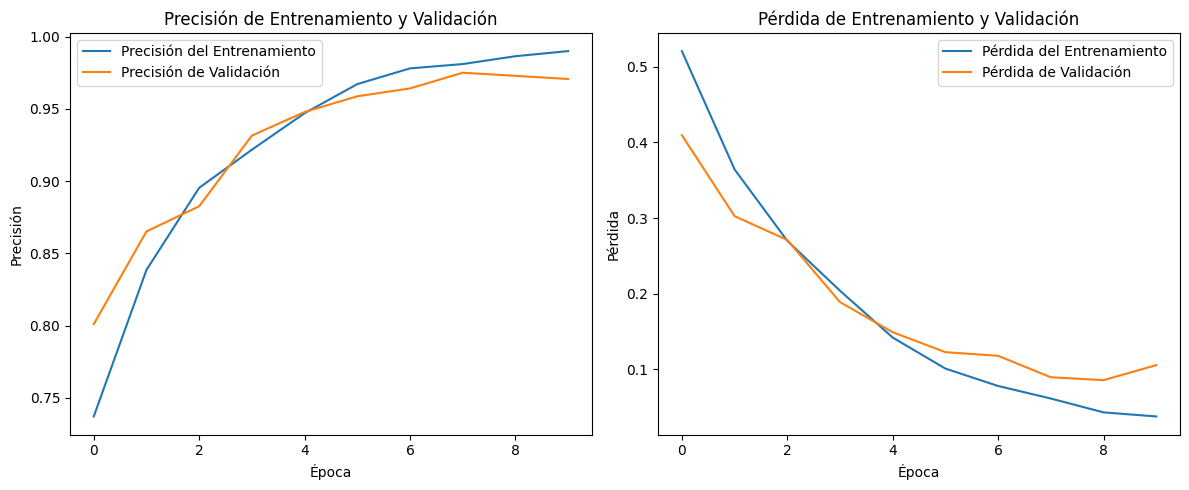

In [98]:
# Gráfico de precisión y pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión del Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida del Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()

In [99]:
# Make predictions with verbose output
y_pred_prob = model.predict(X_test, verbose=1)

# Convert probabilities to binary labels based on a threshold of 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# Create a DataFrame to display actual and predicted labels
results = pd.DataFrame({
    'Etiqueta Actual': y_test.flatten(),  # Adjust according to the shape of your actual labels
    'Etiqueta Predicha': y_pred.flatten()
})

# Display the DataFrame
results


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,Etiqueta Actual,Etiqueta Predicha
0,0,0
1,0,0
2,0,0
3,1,1
4,1,1
...,...,...
915,1,1
916,1,1
917,0,0
918,0,0


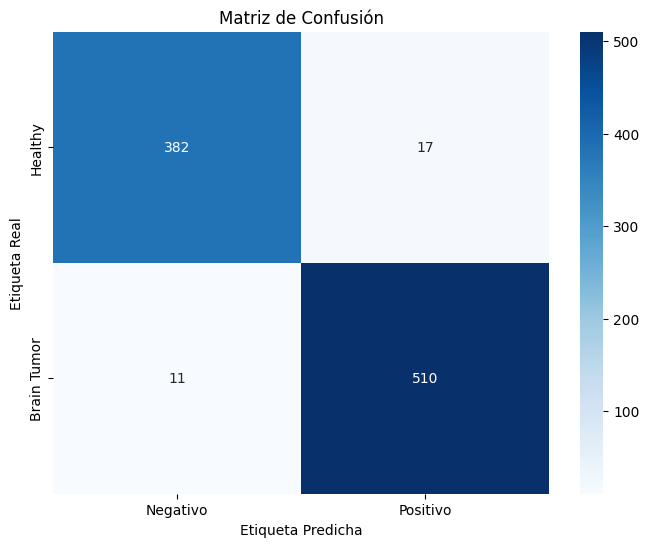

In [162]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Healthy', 'Brain Tumor'])
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

## MODELO 2

In [101]:
# Define the CNN model
# Define the CNN architecture
model2 = Sequential([
    Input(shape=(64,64,1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Using sigmoid for binary classification
])

model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [102]:
history2 = model2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6094 - loss: 0.6363 - val_accuracy: 0.8185 - val_loss: 0.4199
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8193 - loss: 0.4003 - val_accuracy: 0.8761 - val_loss: 0.3007
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.8901 - loss: 0.2848 - val_accuracy: 0.9152 - val_loss: 0.2359
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9211 - loss: 0.1946 - val_accuracy: 0.9370 - val_loss: 0.1830
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9502 - loss: 0.1415 - val_accuracy: 0.9641 - val_loss: 0.1297
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9686 - loss: 0.0936 - val_accuracy: 0.9652 - val_loss: 0.1278
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9784 - loss: 0.0647 - val_accuracy: 0.9707 - val_loss: 0.1129
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9854 - loss: 0.0465 - val_accu

In [103]:
hist_=pd.DataFrame(history2.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.688587,0.567450,0.818478,0.419926
1,0.838043,0.377182,0.876087,0.300661
2,0.883967,0.282013,0.915217,0.235941
3,0.922554,0.187520,0.936957,0.183015
4,0.953261,0.130207,0.964130,0.129742
5,0.969565,0.093355,0.965217,0.127801
6,0.979076,0.063457,0.970652,0.112858
7,0.986141,0.046050,0.968478,0.119766
8,0.990489,0.028585,0.979348,0.098919
9,0.994565,0.018902,0.969565,0.117800


In [104]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model2.evaluate(X_test, y_test)
print("Loss en los datos de prueba:", loss)
print("Precisión en los datos de prueba:", accuracy)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9661 - loss: 0.1125
Loss en los datos de prueba: 0.11779975891113281
Precisión en los datos de prueba: 0.969565212726593


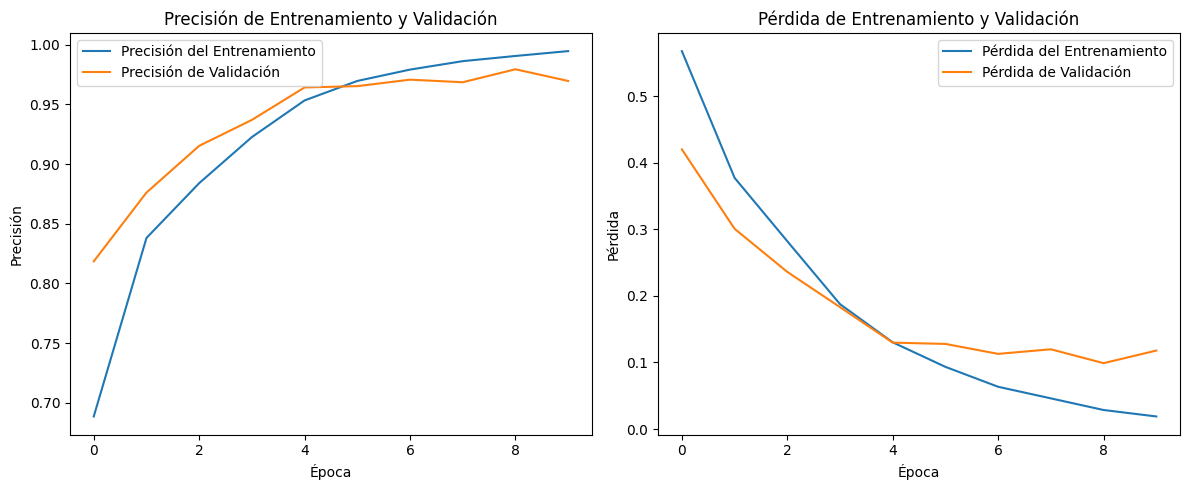

In [105]:
# Gráfico de precisión y pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Precisión del Entrenamiento')
plt.plot(history2.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Pérdida del Entrenamiento')
plt.plot(history2.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


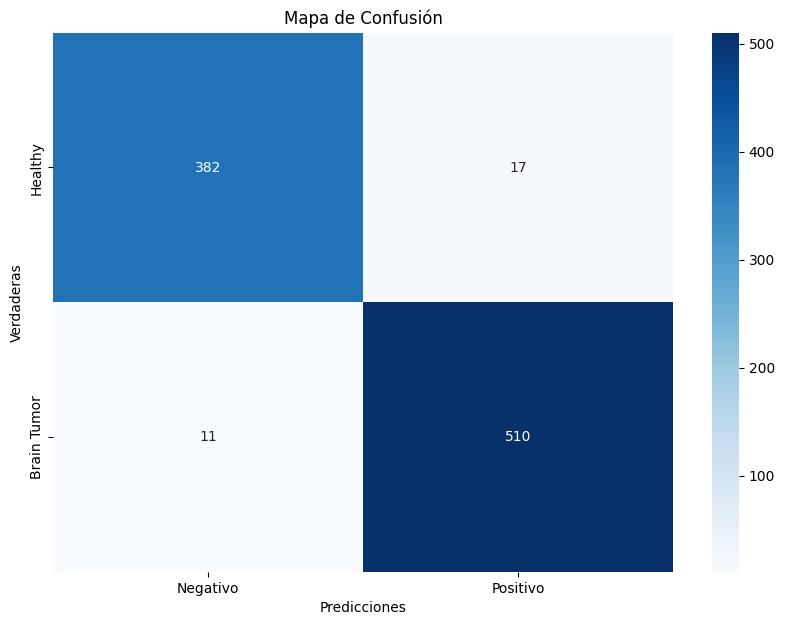

In [163]:
# Predecir las etiquetas para el conjunto de datos de prueba
y_pred = model2.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convierte probabilidades a etiquetas binarias

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión usando seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Healthy', 'Brain Tumor'])
plt.xlabel('Predicciones')
plt.ylabel('Verdaderas')
plt.title('Mapa de Confusión')
plt.show()


In [107]:
# Create a DataFrame to display actual and predicted labels
results = pd.DataFrame({
    'Etiqueta Actual': y_test.flatten(),  # Adjust according to the shape of your actual labels
    'Etiqueta Predicha': y_pred.flatten()
})

# Display the DataFrame
results

,Etiqueta Actual,Etiqueta Predicha
0,0,0
1,0,1
2,0,0
3,1,1
4,1,1
...,...,...
915,1,1
916,1,1
917,0,0
918,0,0


## COMPARACIÓN MODELOS

In [117]:
def compare_models(history, history2, model, model2, X_test, y_test):
    # Comparar precisión
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Modelo 1 - Precisión en Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Modelo 1 - Precisión en Validación')
    plt.plot(history2.history['accuracy'], label='Modelo 2 - Precisión en Entrenamiento')
    plt.plot(history2.history['val_accuracy'], label='Modelo 2 - Precisión en Validación')
    plt.title('Comparación de la Precisión de los Modelos')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Comparar pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Modelo 1 - Pérdida en Entrenamiento')
    plt.plot(history.history['val_loss'], label='Modelo 1 - Pérdida en Validación')
    plt.plot(history2.history['loss'], label='Modelo 2 - Pérdida en Entrenamiento')
    plt.plot(history2.history['val_loss'], label='Modelo 2 - Pérdida en Validación')
    plt.title('Comparación de la Pérdida de los Modelos')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluación en el conjunto de prueba
    score1 = model.evaluate(X_test, y_test, verbose=0)
    score2 = model2.evaluate(X_test, y_test, verbose=0)
    print(f"Modelo 1 - Pérdida: {score1[0]}, Precisión: {score1[1]}")
    print(f"Modelo 2 - Pérdida: {score2[0]}, Precisión: {score2[1]}")


In [118]:
def compare_models(history, history2, model, model2, X_test, y_test):
    # Comparar precisión
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Modelo 1 - Precisión en Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Modelo 1 - Precisión en Validación')
    plt.plot(history2.history['accuracy'], label='Modelo 2 - Precisión en Entrenamiento')
    plt.plot(history2.history['val_accuracy'], label='Modelo 2 - Precisión en Validación')
    plt.title('Comparación de la Precisión de los Modelos')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Comparar pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Modelo 1 - Pérdida en Entrenamiento')
    plt.plot(history.history['val_loss'], label='Modelo 1 - Pérdida en Validación')
    plt.plot(history2.history['loss'], label='Modelo 2 - Pérdida en Entrenamiento')
    plt.plot(history2.history['val_loss'], label='Modelo 2 - Pérdida en Validación')
    plt.title('Comparación de la Pérdida de los Modelos')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluación en el conjunto de prueba
    score1 = model.evaluate(X_test, y_test, verbose=0)
    score2 = model2.evaluate(X_test, y_test, verbose=0)
    print(f"Modelo 1 - Pérdida: {score1[0]}, Precisión: {score1[1]}")
    print(f"Modelo 2 - Pérdida: {score2[0]}, Precisión: {score2[1]}")


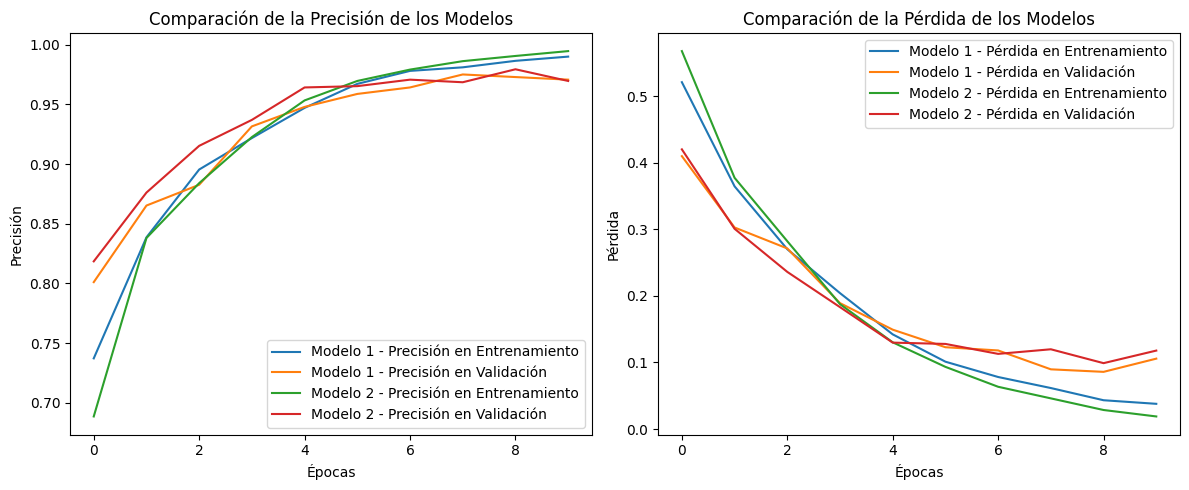

Modelo 1 - Pérdida: 0.1056966483592987, Precisión: 0.970652163028717
Modelo 2 - Pérdida: 0.11779975891113281, Precisión: 0.969565212726593


In [110]:
compare_models(history, history2, model, model2, X_test, y_test)

## PREDICCIÓN

In [164]:
def prepare_image(image_path):
    """Prepara una imagen para ser evaluada por el modelo CNN."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (64, 64))  # Redimensiona la imagen a 64x64
        img = img / 255.0  # Normaliza los valores de los píxeles
        img = np.expand_dims(img, axis=-1)  # Añade una dimensión de canal
        img = np.expand_dims(img, axis=0)  # Añade una dimensión de lote
        return img
    else:
        return None


In [165]:
def predict_tumor_model1(image_path, model):
    """Determina si la imagen contiene un tumor utilizando el modelo CNN."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model.predict(img)
        return "Tumor" if prediction[0][0] > 0.5 else "Healthy"
    else:
        return "La imagen no se encontró o no pudo leerse"


In [166]:
# Cargar el modelo entrenado (asegúrate de que el modelo está correctamente cargado)
# model = cargar_tu_modelo()  # Asume que tienes una función para cargar el modelo

# Ruta de la imagen a evaluar
image_path = 'C:/Users/apeny/Downloads/PRUEBA NO CANCER.png'

# Hacer la predicción
result = predict_tumor_model1(image_path, model)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Healthy


In [167]:
# Ruta de la imagen a evaluar
image_path = 'C:/Users/apeny/Downloads/PRUEBA CANCER O NO.png'

# Hacer la predicción
result = predict_tumor_model1(image_path, model)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Tumor


In [168]:
# Ruta de la imagen a evaluar
image_path = 'C:/Users/apeny/Downloads/PRUEBA CANCER O NO 1.png'

# Hacer la predicción
result = predict_tumor_model1(image_path, model)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Tumor


In [169]:
def predict_tumor_with_prob_model1(image_path, model):
    """Determina si la imagen contiene un tumor y devuelve la probabilidad de la predicción."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model.predict(img)
        probability = prediction[0][0]
        return ("Tumor", probability) if probability > 0.5 else ("Healthy", 1 - probability)
    else:
        return ("La imagen no se encontró o no pudo leerse", None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


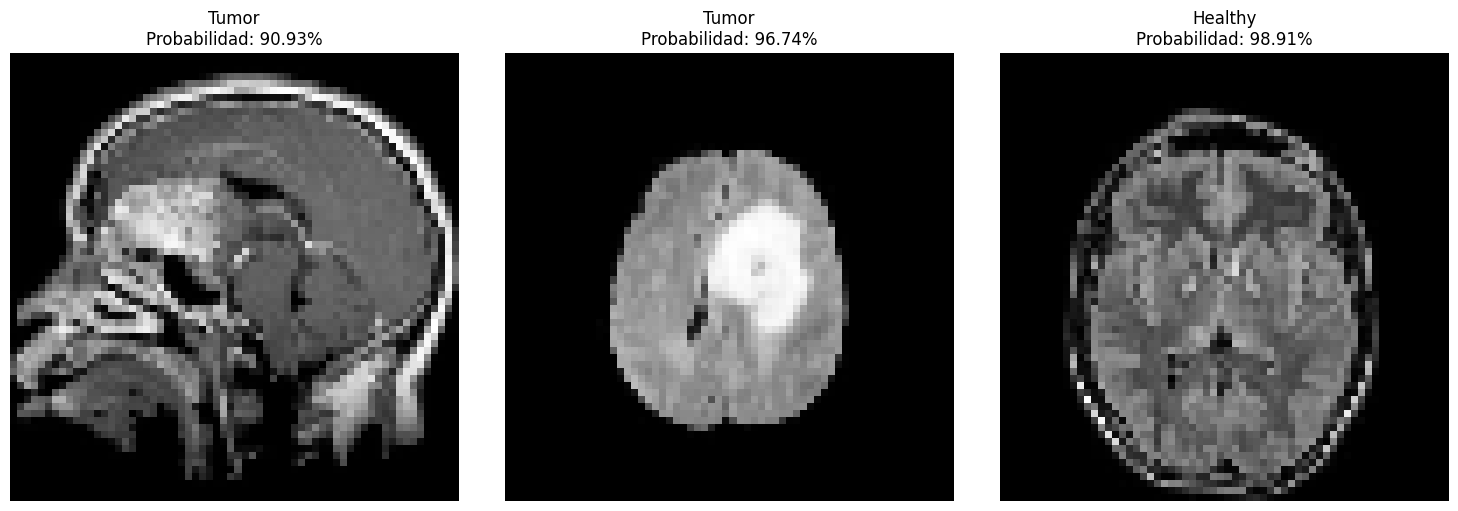

In [170]:
# Rutas de las imágenes
image_paths = [
    'C:/Users/apeny/Downloads/PRUEBA CANCER O NO 1.png',
    'C:/Users/apeny/Downloads/PRUEBA CANCER O NO.png',
    'C:/Users/apeny/Downloads/PRUEBA NO CANCER.png'
]

# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Procesar cada imagen y mostrar
for ax, image_path in zip(axes, image_paths):
    label, prob = predict_tumor_with_prob_model1(image_path, model)
    if label != "La imagen no se encontró o no pudo leerse":
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))
        ax.imshow(img, cmap='gray')
        ax.title.set_text(f'{label}\nProbabilidad: {prob:.2%}')
    else:
        ax.imshow(np.zeros((64, 64)), cmap='gray')
        ax.title.set_text(label)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [171]:
def predict_tumor_model2(image_path, model2):
    """Determina si la imagen contiene un tumor utilizando el modelo CNN."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model2.predict(img)
        return "Tumor" if prediction[0][0] > 0.5 else "Healthy"
    else:
        return "La imagen no se encontró o no pudo leerse"

In [172]:
# Ruta de la imagen a evaluar
image_path = 'C:/Users/apeny/Downloads/PRUEBA NO CANCER.png'

# Hacer la predicción
result = predict_tumor_model2(image_path, model2)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Healthy


In [173]:
# Ruta de la imagen a evaluar
image_path = 'C:/Users/apeny/Downloads/PRUEBA CANCER O NO.png'

# Hacer la predicción
result = predict_tumor_model2(image_path, model2)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tumor


In [174]:
# Ruta de la imagen a evaluar
image_path = 'C:/Users/apeny/Downloads/PRUEBA CANCER O NO 1.png'

# Hacer la predicción
result = predict_tumor_model2(image_path, model2)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Tumor


In [175]:
def predict_tumor_with_prob_model2(image_path, model2):
    """Determina si la imagen contiene un tumor y devuelve la probabilidad de la predicción."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model2.predict(img)
        probability = prediction[0][0]
        return ("Tumor", probability) if probability > 0.5 else ("Healthy", 1 - probability)
    else:
        return ("La imagen no se encontró o no pudo leerse", None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


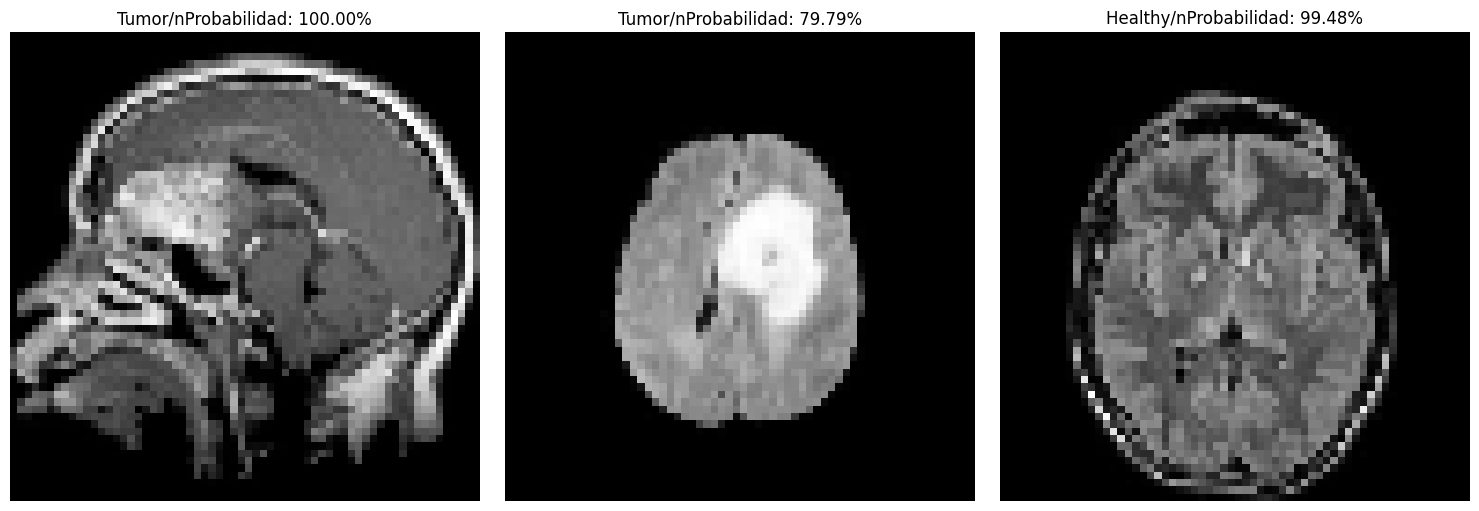

In [176]:
# Rutas de las imágenes
image_paths = [
    'C:/Users/apeny/Downloads/PRUEBA CANCER O NO 1.png',
    'C:/Users/apeny/Downloads/PRUEBA CANCER O NO.png',
    'C:/Users/apeny/Downloads/PRUEBA NO CANCER.png'
]

# Cargar modelo
# model = cargar_tu_modelo()  # Asume que tienes una función para cargar el modelo

# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Procesar cada imagen y mostrar
for ax, image_path in zip(axes, image_paths):
    label, prob = predict_tumor_with_prob_model1(image_path, model2)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))  # Asegura que todas las imágenes se muestren al mismo tamaño
    
    ax.imshow(img, cmap='gray')
    ax.title.set_text(f'{label}/nProbabilidad: {prob:.2%}')
    ax.axis('off')

plt.tight_layout()
plt.show()